In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import time
import torch.nn as nn
# %matplotlib inline
import os
import torch
from torch.autograd import Variable
import math
dtype = torch.cuda.FloatTensor


In [2]:
base_dir = 'inpainting_dataset/'
img = base_dir+'justin.png'
mask = base_dir+'justin_mask.png'

In [3]:
def preprocess_input(img, mask):
    img = Image.open(img)
    plt.imshow(img)
    mask = Image.open(mask)
    plt.figure()
    plt.imshow(mask,cmap='gray')
    img = np.array(img).transpose(2,0,1)
    img = img[:3,:512,:512]/255
    mask = np.array(mask)[None, :]/255
    processed_img = img*mask
    plt.figure()
    plt.imshow(processed_img.transpose(1,2,0))
    img = (torch.from_numpy(img)[None,:]).type(dtype)
    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

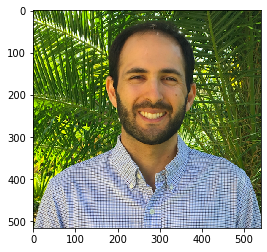

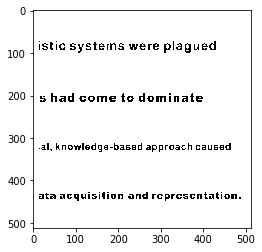

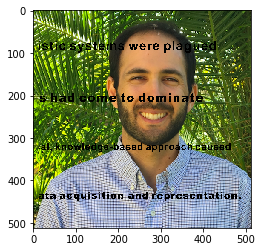

In [4]:
img, mask, processed_img = preprocess_input(img, mask)

In [7]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def act(activation_method = 'LeakyReLU'):
    if activation_method=='ReLU':
        return nn.ReLU()
    elif activation_method =='LeakyReLU':
        return nn.LeakyReLU(0.2, inplace=True)
    elif activation_method=='sigmoid':
        return nn.Sigmoid()
    else:
        return nn.Tanh()

def conv(in_f, out_f, kernel_size, stride=1): 
    res = []
    res.append(nn.ReflectionPad2d(int((kernel_size - 1) / 2)))
    res.append(nn.Conv2d(in_f, out_f, kernel_size, stride, padding=0))
    return nn.Sequential(*res)

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode, act_fun, ):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    for i in range(len(c_down)):
        temp_layers = []
        temp_layers.append(nn.ReflectionPad2d(int((k_down - 1) / 2)))
        temp_layers.append(nn.Conv2d(input_depth, c_down[i], k_down, 2))
        temp_layers.append(nn.BatchNorm2d(c_down[i]))
        temp_layers.append(act(act_fun))
        
        temp_layers.append(nn.ReflectionPad2d(int((k_down - 1) / 2)))
        temp_layers.append(nn.Conv2d(c_down[i], c_down[i], k_down, 1))
        temp_layers.append(nn.BatchNorm2d(c_down[i]))
        temp_layers.append(act(act_fun))
        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            temp_layers.append(deeper_main)
            temp_layers.append(nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                skip_layers = []
                skip_layers.append(conv(input_depth, c_skip[i], k_skip))
                skip_layers.append(nn.BatchNorm2d(c_skip[i]))
                skip_layers.append(act(act_fun))
                model_tmp.add(Concat(1, nn.Sequential(*skip_layers), nn.Sequential(*temp_layers)))
            else:
                model_tmp.add(nn.Sequential(*temp_layers))
            model_tmp.add(nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add(conv(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1))
            
        else:#last layer
            temp_layers.append(nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                skip_layers = []
                skip_layers.append(conv(input_depth, c_skip[i], k_skip))
                skip_layers.append(nn.BatchNorm2d(c_skip[i]))
                skip_layers.append(act(act_fun))
                model_tmp.add(Concat(1, nn.Sequential(*skip_layers), nn.Sequential(*temp_layers)))
            else:
                model_tmp.add(nn.Sequential(*temp_layers))
            model_tmp.add(nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add(conv(c_skip[i] + c_down[i], c_up[i], k_up, 1))

        model_tmp.add(nn.BatchNorm2d(c_up[i]))
        model_tmp.add(act(act_fun))
        model_tmp.add(conv(c_up[i], c_up[i], 1))
        model_tmp.add(nn.BatchNorm2d(c_up[i]))
        model_tmp.add(act(act_fun))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add(conv(c_up[0], c_out, 1))
    model.add(nn.Sigmoid())

    return model

Sequential(
  (1): Concat(
    (layer1): Sequential(
      (0): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer2): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Sequential(
        (1): Concat(
          (layer1): Sequential(
            (0): Sequential(
              (0): ReflectionPad2d((0, 0, 0, 0))
 

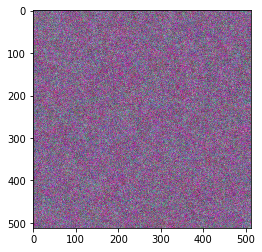

Iteration 00100  Loss 0.019651  PSNR 17.066226


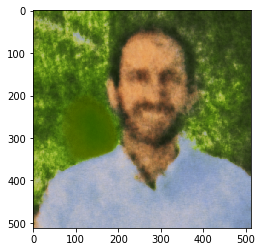

Iteration 00200  Loss 0.014154  PSNR 18.491125


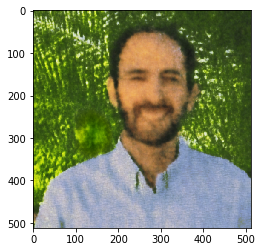

Iteration 00300  Loss 0.011446  PSNR 19.413280


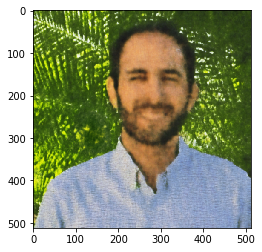

Iteration 00400  Loss 0.009452  PSNR 20.244670


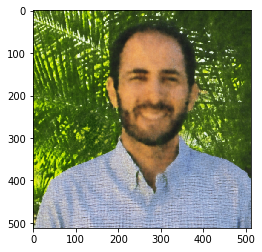

Iteration 00500  Loss 0.007700  PSNR 21.135144


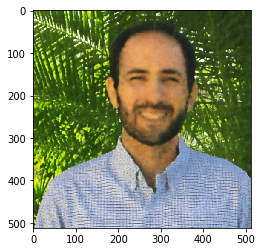

Iteration 00600  Loss 0.006079  PSNR 22.162000


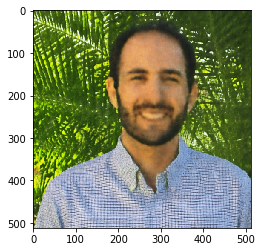

Iteration 00700  Loss 0.005046  PSNR 22.970887


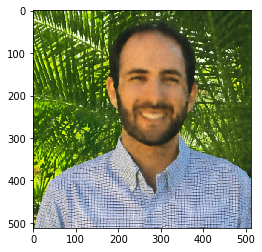

Iteration 00800  Loss 0.004279  PSNR 23.686791


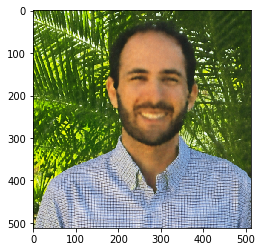

Iteration 00900  Loss 0.003635  PSNR 24.395298


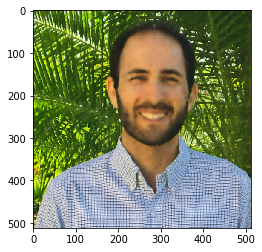

Iteration 01000  Loss 0.003106  PSNR 25.078034


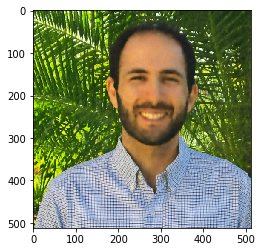

Iteration 01100  Loss 0.002762  PSNR 25.588007


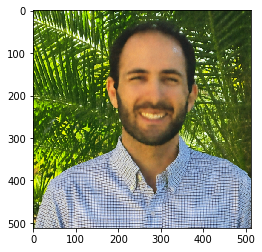

Iteration 01200  Loss 0.002479  PSNR 26.056361


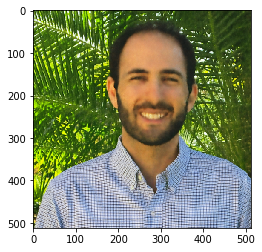

Iteration 01300  Loss 0.002186  PSNR 26.602535


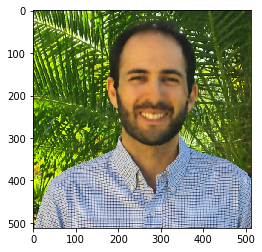

Iteration 01400  Loss 0.001928  PSNR 27.148221


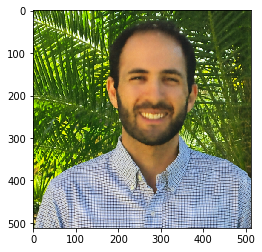

Iteration 01500  Loss 0.001748  PSNR 27.575637


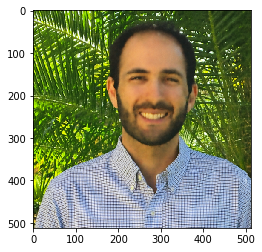

Iteration 01600  Loss 0.001614  PSNR 27.920022


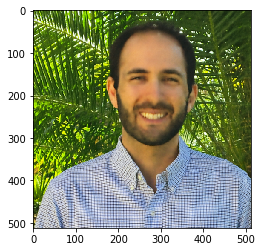

Iteration 01700  Loss 0.001473  PSNR 28.317642


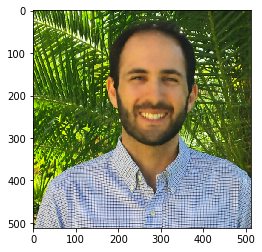

Iteration 01800  Loss 0.001343  PSNR 28.719197


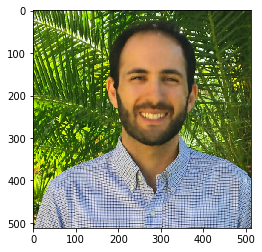

Iteration 01900  Loss 0.001205  PSNR 29.191615


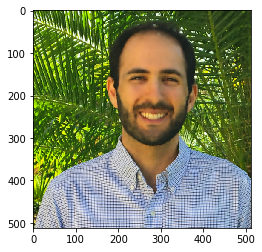

Iteration 02000  Loss 0.001091  PSNR 29.621215


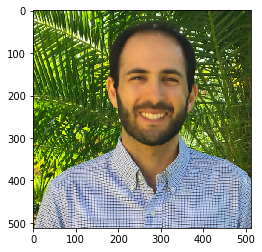

Iteration 02100  Loss 0.000971  PSNR 30.129004


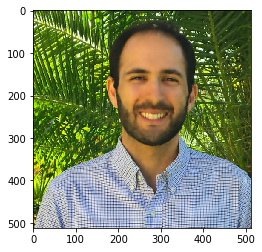

Iteration 02200  Loss 0.000920  PSNR 30.363734


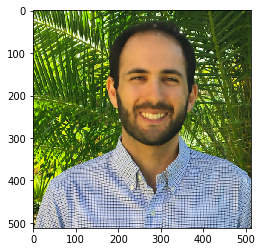

Iteration 02300  Loss 0.000839  PSNR 30.762395


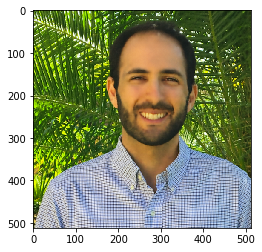

Iteration 02400  Loss 0.000768  PSNR 31.148624


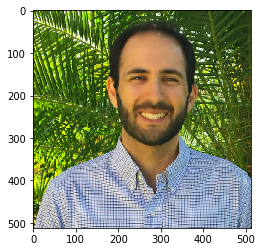

Iteration 02500  Loss 0.000731  PSNR 31.362418


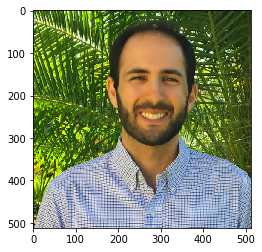

Iteration 02600  Loss 0.000656  PSNR 31.831275


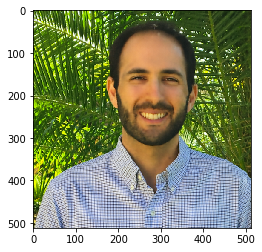

Iteration 02700  Loss 0.000605  PSNR 32.184104


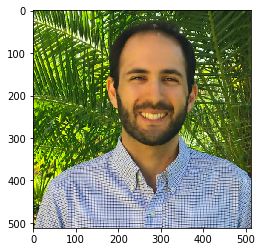

In [ ]:
input_depth = 32
LR = 0.01 
num_iter = 6001
reg_noise_std = 0.03

model = skip(input_depth, img.shape[1], 
               c_down = [128] * 5,
               c_up =   [128] * 5,
               c_skip =    [128] * 5,  
               k_up = 3, k_down = 3, 
               upsample_mode='nearest', k_skip=1,
               act_fun='LeakyReLU').type(dtype)
print(model)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, img.shape[2], img.shape[3]])
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)

    loss = mse(out * mask, img * mask)
    loss.backward()
    
    optimizer.step()
    PSNR.append(10 * math.log10(1 / loss.item()))   
    if i % 100 == 0:
        print('Iteration %05d  Loss %f  PSNR %f' % (i, loss.item(), 10 * math.log10(1 / loss.item())))
        out = out.detach().cpu().numpy()[0]
        plt.figure()
        plt.imshow(out.transpose(1,2,0))
        plt.show()

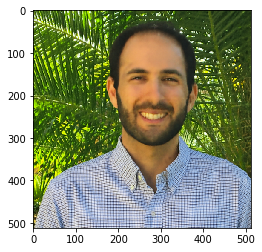

In [8]:
# out = out.detach().cpu().numpy()[0]
#         print(out.shape)
plt.figure()
plt.imshow(out.transpose(1,2,0))
plt.show()

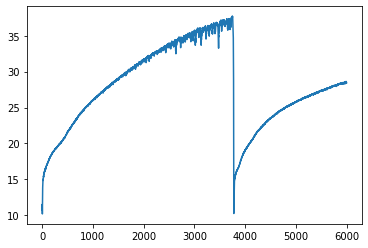

In [9]:
plt.plot(PSNR)